# 迁移大型网络

在这节课中，我们将学会如何迁移一个大型
的已经被训练好的卷积神经网络来帮助我们在很小的数据集上完成训练，并得到比较高的识别精度。
同时，在本文件中，我们还展示了如何实用GPU来进行计算

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

## 一、加载数据

在这里我们将学会如何运用PyTorch的dataset来加载硬盘上的大量图像  
只要我们将大量的图像文件都放入指定的文件夹下(训练数据集在data/train下面，校验数据集在data/val下面)  
并且将不同的类别分别放到不同的文件夹下。  
例如在这个例子中，我们有两个类别：bees和ants，我就需要在硬盘上建立两个文件夹：bees和ants。

In [2]:
data_dir = 'data'
image_size = 224
# 加载的过程将会对图像自动作如下的图像增强操作：
# 1. 随机从原始图像中切下来一块224*224大小的区域
# 2. 随机水平翻转图像
# 3. 将图像的色彩数值标准化
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                    transforms.Compose([
                                        transforms.RandomResizedCrop(image_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
                                    )

# 加载校验数据集，对每个加载的数据进行如下处理：
# 1. 放大到256*256像素
# 2. 从中心区域切割下224*224大小的图像区域
# 3. 将图像的色彩数值标准化
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                  transforms.Compose([
                                      transforms.Resize(256),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])
                                  )

# 创建相应的数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

# 读取得出数据中的分类类别数['ants', 'bees']
num_classes = len(train_dataset.classes)

# 检测本机器是否安装GPU，将检测结果记录在布尔变量use_cuda中
use_cuda = torch.cuda.is_available()

# 当可用GPU的时候，将新建立的张量自动加载到GPU中
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

In [3]:
print(use_cuda)

True


images_size: torch.Size([4, 3, 224, 224])
out_size: torch.Size([3, 228, 906])


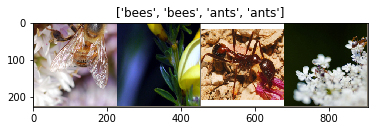

In [21]:
def imshow(inp, title=None):
    # 将一张图打印显示出来，inp为一个张量，title为显示在图像上的文字
    
    #一般的张量格式为：channels*image_width*image_height
    #而一般的图像为image_width*image_height*channels所以，需要将channels转换到最后一个维度
    inp = inp.cpu() if use_cuda else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    #由于在读入图像的时候所有图像的色彩都标准化了，因此我们需要先调回去
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    #将图像绘制出来
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# 获取第一个图像batch和标签(标签对应文件夹)
images, labels = next(iter(train_loader)) 
print("images_size:", images.shape)

# 将这个batch中的图像制成表格绘制出来
out = torchvision.utils.make_grid(images)
print("out_size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

## 二、加载一个卷积神经网络作为对比
## 三、加载已训练好的Residual Network进行迁移学习预训练

In [5]:
# 加载模型库中的residual network，并设置pretrained为true，这样便可加载相应的权重
net = models.resnet18(pretrained=True)
# 如果存在GPU，就将网络加载到GPU上
net = net.cuda() if use_cuda else net
# 将网络的架构打印出来
net

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    rights = rights.cpu() if use_cuda else rights
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [18]:
# 重新定义一个全新的线性层，它的输出为2，原本是1000
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
record = [] #记录准确率等数值的容器

#开始训练循环
num_epochs = 20
net.train(True)
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    train_rights = []
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = rightness(output, target)
        train_rights.append(right)
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())
        
    # train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
    
    #在测试集上分批运行，并计算总的正确率
    net.eval()
    vals = []
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        output = net(data)
        val = rightness(output, target)
        vals.append(val)
    
    #计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0].numpy()/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))       
    record.append([np.mean(train_losses), train_r[0].numpy() / train_r[1], val_r[0].numpy()/val_r[1]])  

训练周期: 0 	Loss: 0.623920	训练正确率: 64.34%, 校验正确率: 81.05%
训练周期: 1 	Loss: 0.360285	训练正确率: 86.89%, 校验正确率: 85.62%
训练周期: 2 	Loss: 0.237096	训练正确率: 91.39%, 校验正确率: 91.50%
训练周期: 3 	Loss: 0.153837	训练正确率: 94.26%, 校验正确率: 93.46%
训练周期: 4 	Loss: 0.131318	训练正确率: 95.08%, 校验正确率: 92.16%
训练周期: 5 	Loss: 0.120091	训练正确率: 95.08%, 校验正确率: 94.12%
训练周期: 6 	Loss: 0.149416	训练正确率: 95.49%, 校验正确率: 90.85%
训练周期: 7 	Loss: 0.086675	训练正确率: 97.54%, 校验正确率: 92.81%
训练周期: 8 	Loss: 0.063391	训练正确率: 98.36%, 校验正确率: 92.81%
训练周期: 9 	Loss: 0.107808	训练正确率: 95.49%, 校验正确率: 95.42%
训练周期: 10 	Loss: 0.114086	训练正确率: 95.08%, 校验正确率: 89.54%
训练周期: 11 	Loss: 0.064261	训练正确率: 98.77%, 校验正确率: 94.77%
训练周期: 12 	Loss: 0.096746	训练正确率: 94.67%, 校验正确率: 94.12%
训练周期: 13 	Loss: 0.088488	训练正确率: 96.31%, 校验正确率: 93.46%
训练周期: 14 	Loss: 0.117017	训练正确率: 95.90%, 校验正确率: 88.24%
训练周期: 15 	Loss: 0.124694	训练正确率: 95.90%, 校验正确率: 94.12%
训练周期: 16 	Loss: 0.073395	训练正确率: 97.13%, 校验正确率: 94.12%
训练周期: 17 	Loss: 0.074358	训练正确率: 97.13%, 校验正确率: 94.12%
训练周期: 18 	Loss: 0.080598	训练正确率: 95.90%

Text(0, 0.5, 'Error Rate')

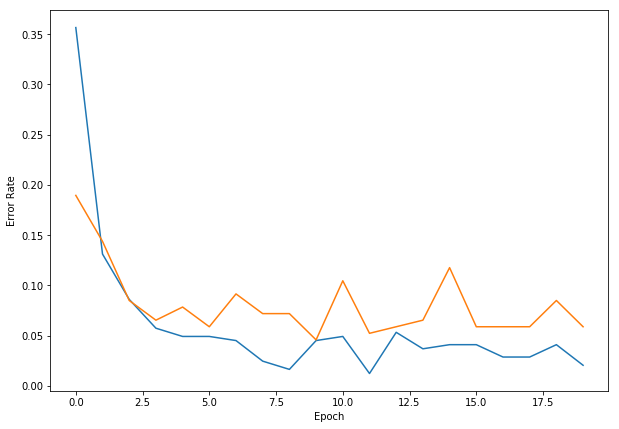

In [19]:
# 打印误差率曲线
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
plt.figure(figsize = (10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

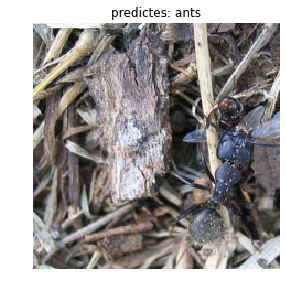

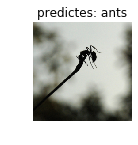

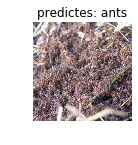

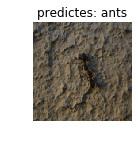

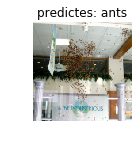

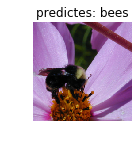

In [22]:
# 将预训练的模型用语测试数据，打印其分类效果
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(val_loader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(val_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()

## 四、迁移Residual网络并固定权值

In [23]:
# 加载residual网络模型
net = torchvision.models.resnet18(pretrained=True)
# 将模型放入GPU中
net = net.cuda() if use_cuda else net

# 循环网络，将所有参数设为不更新梯度信息
for param in net.parameters():
    param.requires_grad = False

# 将网络最后一层现行层换掉
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss() #Loss函数的定义
# 仅将线性层的参数放入优化器中
optimizer = optim.SGD(net.fc.parameters(), lr = 0.001, momentum=0.9)

record = [] #记录准确率等数值的容器

#开始训练循环
num_epochs = 20
net.train(True) # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = [] #记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach() #data为图像，target为标签
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #完成一次预测
        loss = criterion(output, target) #计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降
        right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

    
     #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))

    #在测试集上分批运行，并计算总的正确率
    net.eval() #标志模型当前为运行阶段
    vals = []
    #对测试数据集进行循环
    for data, target in val_loader:
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #将特征数据喂入网络，得到分类的输出
        val = rightness(output, target) #获得正确样本数以及总样本数
        vals.append(val) #记录结果

    #计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0].numpy()/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))       
    record.append([np.mean(train_losses), train_r[0].numpy() / train_r[1], val_r[0].numpy()/val_r[1]])

训练周期: 0 	Loss: 0.623525	训练正确率: 65.16%, 校验正确率: 85.62%
训练周期: 1 	Loss: 0.241545	训练正确率: 89.34%, 校验正确率: 92.16%
训练周期: 2 	Loss: 0.195457	训练正确率: 92.21%, 校验正确率: 95.42%
训练周期: 3 	Loss: 0.128164	训练正确率: 96.31%, 校验正确率: 86.93%
训练周期: 4 	Loss: 0.120975	训练正确率: 94.26%, 校验正确率: 92.81%
训练周期: 5 	Loss: 0.121348	训练正确率: 94.26%, 校验正确率: 93.46%
训练周期: 6 	Loss: 0.121365	训练正确率: 94.26%, 校验正确率: 94.77%
训练周期: 7 	Loss: 0.100287	训练正确率: 96.31%, 校验正确率: 94.77%
训练周期: 8 	Loss: 0.128822	训练正确率: 94.67%, 校验正确率: 94.77%
训练周期: 9 	Loss: 0.079027	训练正确率: 97.54%, 校验正确率: 94.77%
训练周期: 10 	Loss: 0.077525	训练正确率: 95.49%, 校验正确率: 94.12%
训练周期: 11 	Loss: 0.071416	训练正确率: 96.72%, 校验正确率: 94.77%
训练周期: 12 	Loss: 0.144350	训练正确率: 94.67%, 校验正确率: 94.12%
训练周期: 13 	Loss: 0.071650	训练正确率: 97.13%, 校验正确率: 94.12%
训练周期: 14 	Loss: 0.089217	训练正确率: 96.31%, 校验正确率: 95.42%
训练周期: 15 	Loss: 0.072943	训练正确率: 97.95%, 校验正确率: 95.42%
训练周期: 16 	Loss: 0.068807	训练正确率: 97.54%, 校验正确率: 94.77%
训练周期: 17 	Loss: 0.126598	训练正确率: 94.26%, 校验正确率: 94.12%
训练周期: 18 	Loss: 0.079574	训练正确率: 95.49%

Text(0, 0.5, 'Error Rate')

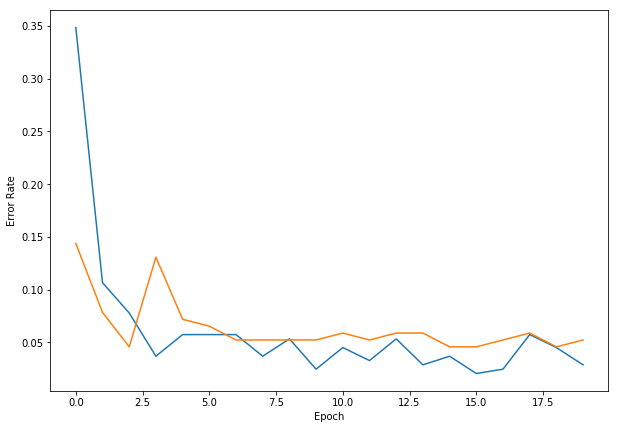

In [24]:
# 打印误差曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
#plt.plot(x)
plt.figure(figsize = (10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

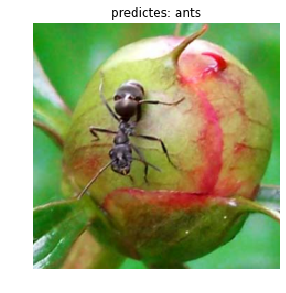

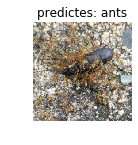

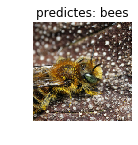

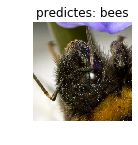

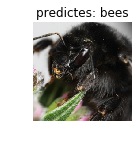

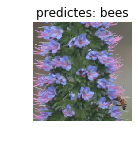

In [25]:
# 展示分类结果
visualize_model(best_model)

plt.ioff()
plt.show()